## Цели и задачи проекта, описание исходных и обработанных данных и признаков.
* **Цели и задачи:** по последовательности из нескольких веб-сайтов, посещенных подряд одним и тем же человеком, мы будем идентифицировать этого человека. Идея такая: пользователи Интернета по-разному переходят по ссылкам, и это может помогать их идентифицировать (кто-то сначала в почту, потом про футбол почитать, затем новости, контакт, потом наконец – работать, кто-то – сразу работать, если это возможно).
* **Исходные данные:**
    * Признаки **site_i** – это индексы посещенных сайтов (расшифровка дана в pickle-файле со словарем site_dic.pkl)
    * Признаки **time_j** – время посещения сайтов site_j
    * Целевой признак **target** – факт того, что сессия принадлежит Элис (то есть что именно Элис ходила по всем этим сайтам)


## Первичный анализ признаков и создание новых

Загрузим данные и обьеденим их в один датасет, для дальнейшего добавления дополнительных признаков

In [15]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV,  learning_curve,  validation_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVC
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler

In [16]:
times = ['time%s' % i for i in range(1, 11)]
sites = ['site%s' % i for i in range(1, 11)]

In [156]:
PATH_TO_DATA = 'capstone_user_identification'

train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id', parse_dates=times)
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id', parse_dates=times)
# y = train_df['target'].values

In [157]:
train_df = pd.concat([train_df[(train_df['target']==0)], train_df[(train_df['target']==1) & (train_df['time1'].dt.year*100+train_df['time1'].dt.year>201309)]])
y = train_df['target'].values

In [158]:
train_test_df = pd.concat([train_df.drop("target", axis = 1), test_df])
tt_df_times = train_test_df[times]
tt_df_sites = train_test_df[sites].fillna(0).astype('int')

In [159]:
def part_of_day(start_hour):
    if 6 <= start_hour < 10: 
        return 0
    elif 10 <= start_hour < 17: 
        return 1
    elif 17 <= start_hour <= 24: 
        return 2
    elif 0 <= start_hour <= 5: 
        return 3
def count_unique(sites):
    n = []
    for i in range(len(sites)):
        n.append(sites.iloc[i].nunique()-
                      int(0 in sites.iloc[i].values))
    return n
def test(data, sites_df):
    res = pd.DataFrame()
    start = data.min(axis=1, skipna=True)
    finish = data.max(axis=1, skipna=True)
#     data = data.replace(np.datetime64('NaT'), 0)
    ## Разбитие длин сессий
    diff = finish - start
    res['diff'] = diff.apply(lambda ts: int(ts.total_seconds()))
    ## Создаем новые признаки на основе времени
    ## Для начала классифицируем по частям дням
    temp = start.dt.hour
    res['hour'] = temp
    res['part_of_day'] = temp.apply(part_of_day)
#     res['morning'] = ((6 <= temp) & (temp < 10)).astype('int')
#     res['day'] = ((10 <= temp) & (temp < 17)).astype('int')
#     res['evening'] = ((17 <= temp) & (temp <= 24)).astype('int')
#     res['night'] = ((0 <= temp) & (temp < 5)).astype('int')

    ## Теперь укажем какой день недели и дополнительно является ли день выходным
    temp = start.dt.dayofweek
    res['dayofweek'] = temp
#     res['mon'] = (temp==0).astype('int')
#     res['thu'] = (temp==1).astype('int')
#     res['the'] = (temp==2).astype('int')
#     res['tue'] = (temp==3).astype('int')
#     res['fri'] = (temp==4).astype('int')
#     res['sat'] = (temp==5).astype('int')
#     res['sun'] = (temp==6).astype('int')
    res['holiday'] = ((temp == 5 ) | (temp == 6)).astype('int')
    ## укажем месяц
    temp = start.dt.month
    res['month'] = temp
    ## и год
    temp = start.dt.year
    res['year'] = temp
    ## Возмоно сцепление год+месяц будет полезней чем просто месяц
    res['year_month'] = temp*100 + res['month']
    ## Добавим число уникальных сайтов в сессии
    res['nunique'] = count_unique(sites_df)
    
    return res

**Создадим новые признаки:** Продолжительность сессии, часть дня, день недели, выходные, месяц, год, количество уникальных сайтов в сессии 

In [160]:
tt_df_feats= test(tt_df_times, tt_df_sites)
tt_df_feats.head(10)

,diff,hour,part_of_day,dayofweek,holiday,month,year,year_month,nunique
session_id,,,,,,,,,
1,0,10,1,3,0,2,2014,201402,1
2,26,11,1,5,1,2,2014,201402,7
3,7,16,1,0,0,12,2013,201312,4
4,270,10,1,4,0,3,2014,201403,1
5,246,10,1,4,0,2,2014,201402,4
6,686,15,1,1,0,3,2014,201403,2
7,102,16,1,3,0,2,2014,201402,7
8,6,10,1,4,0,4,2013,201304,7
9,45,16,1,0,0,3,2014,201403,7


## Первичный визуальный анализ признаков

Для начала сделаем датасет для анализа признаков

In [161]:
an_df = tt_df_feats[:len(y)]
an_df['target'] = y

Сперва посмотрим на различие по частям дня. 
Из графика понятно, что Элис:
* В сети вечером чаще, чем остальная совокупность пользователей
* В сети утром реже, чем остальная совокупность пользователей

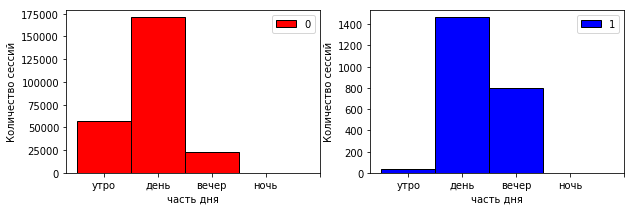

In [162]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
color_dic = {1:'blue', 0:'red'}
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(an_df, 'target')): 
    bins = range(0, 5)
    temp = sub_df['part_of_day']
    axes[idx].hist(temp, label=user, color=color_dic[user], edgecolor='black', bins = bins, align = 'left')     
    axes[idx].set_xlabel('часть дня')
    axes[idx].set_ylabel('Количество сессий')
    axes[idx].legend()
    axes[idx].set_xticks(range(0, 5))
    
    axes[idx].set_xticklabels(["утро", "день","вечер", "ночь"])

Затем на различие продолжительности сессии. 

Сдесь понятно что сессии Элис, по продолжительности распределения практически пропорциональны, остальным пользователям

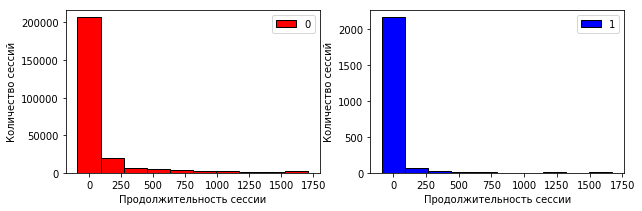

In [163]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

for idx, (user, sub_df) in  enumerate(pd.groupby(an_df, 'target')): 
    temp = sub_df['diff']
    axes[idx].hist(temp, label=user, color=color_dic[user], edgecolor='black', align = 'left')     
    axes[idx].set_xlabel('Продолжительность сессии')
    axes[idx].set_ylabel('Количество сессий')
    axes[idx].legend()

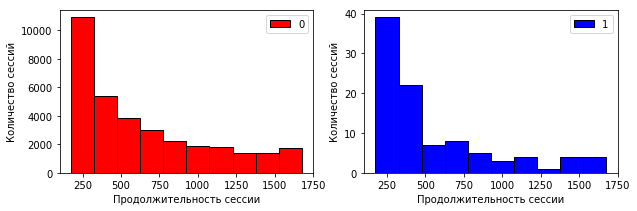

In [164]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

for idx, (user, sub_df) in  enumerate(pd.groupby(an_df, 'target')): 
    temp = sub_df['diff']
    axes[idx].hist(temp, label=user, color=color_dic[user], edgecolor='black', align = 'left', range = (250, 1750))     
    axes[idx].set_xlabel('Продолжительность сессии')
    axes[idx].set_ylabel('Количество сессий')
    axes[idx].legend()

День недели.

Как видно:
* Элис реже остальных пользователей сидит в выходные, и вообще не сидит по воскресеньям
* Также практически полностью отсутствуют активность по средам
* Пик в отличии от остальной совокупность в понедельники

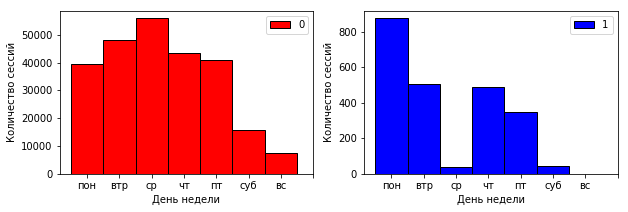

In [165]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(an_df, 'target')): 
    bins = range(0, 8)
    temp = sub_df['dayofweek']
    axes[idx].hist(temp, label=user, color=color_dic[user], edgecolor='black', bins = bins, align = 'left')     
    axes[idx].set_xlabel('День недели')
    axes[idx].set_ylabel('Количество сессий')
    axes[idx].legend()
    axes[idx].set_xticks(range(0, 8))
    
    axes[idx].set_xticklabels(["пон", "втр","ср", "чт", "пт", "суб", "вс"])

Выходные 

У Элис активность по выходным ниже

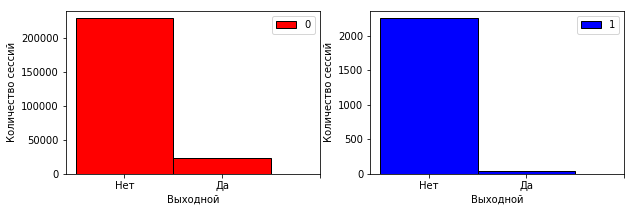

In [166]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(an_df, 'target')): 
    bins = range(0, 3)
    temp = sub_df['holiday']
    axes[idx].hist(temp, label=user, color=color_dic[user], edgecolor='black', bins = bins, align = 'left')     
    axes[idx].set_xlabel('Выходной')
    axes[idx].set_ylabel('Количество сессий')
    axes[idx].legend()
    axes[idx].set_xticks(range(0, 3))
    
    axes[idx].set_xticklabels(['Нет','Да'])

Месяц

Исходя из графика:
* Элис полностью оффлайн с мая по август и еще в октябре
* У Элис активность ниже активность в сентябре, но выше в ноябре и намного выше в сентябре

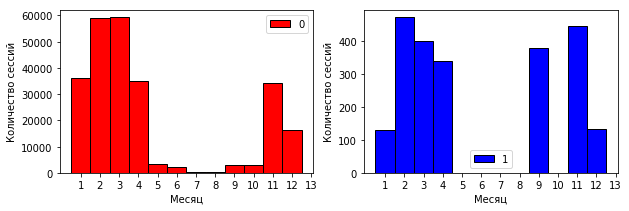

In [167]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(an_df, 'target')): 
    bins = range(1, 14)
    temp = sub_df['month']
    axes[idx].hist(temp, label=user, color=color_dic[user], edgecolor='black', bins = bins, align = 'left')     
    axes[idx].set_xlabel('Месяц')
    axes[idx].set_ylabel('Количество сессий')
    axes[idx].legend()
    axes[idx].set_xticks(range(1, 14))

Год

У Элис пропорция данных по годам более равносерна распределена чем у остальных данных

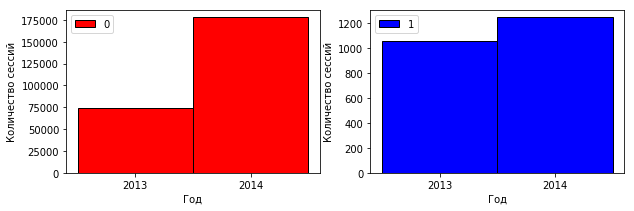

In [168]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(an_df, 'target')): 
    bins = range(2013, 2016)
    temp = sub_df['year']
    axes[idx].hist(temp, label=user, color=color_dic[user], edgecolor='black', bins =bins, align = 'left')     
    axes[idx].set_xlabel('Год')
    axes[idx].set_ylabel('Количество сессий')
    axes[idx].legend()
    axes[idx].set_xticks(range(2013, 2015))

Уникальные сайты

Распределение уникальных сайтов сессии,различаются, у Элис оно больше похоже на нормальное. 

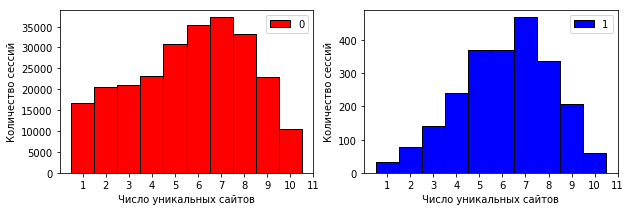

In [169]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(an_df, 'target')): 
    bins = range(1, 12)
    temp = sub_df['nunique']
    axes[idx].hist(temp, label=user, color=color_dic[user], edgecolor='black', bins = bins, align = 'left')     
    axes[idx].set_xlabel('Число уникальных сайтов')
    axes[idx].set_ylabel('Количество сессий')
    axes[idx].legend()
    axes[idx].set_xticks(range(1, 12))

## Предобработка данных для обучения

In [ ]:
tt_df_feats.head()

,diff,hour,part_of_day,dayofweek,holiday,month,year,year_month,nunique
session_id,,,,,,,,,
1,0,10,1,3,0,2,2014,201402,1
2,26,11,1,5,1,2,2014,201402,7
3,7,16,1,0,0,12,2013,201312,4
4,270,10,1,4,0,3,2014,201403,1
5,246,10,1,4,0,2,2014,201402,4


Сделаем dummies

In [ ]:
ohe_columns = ['hour', 'part_of_day', 'dayofweek', 'month', 'year', 'year_month', 'nunique']
not_ohe_columns = ['diff', 'holiday']

tt_df_dumms = pd.get_dummies(tt_df_feats, columns=ohe_columns, sparse=True, drop_first=True)

Трансформируем в sparse датасет со списком сайтов

In [ ]:
def get_sparse_matrix(matrix):
    X = matrix.values
    
    i = 0
    data = list()
    col = list()
    rows = list()
    for row in X:
        unique, counts = np.unique(row, return_counts=True)
        dic = dict(zip(unique, counts))
        for k in dic:
            if k != 0:
                data.append(dic[k])
                rows.append(i)
                col.append(k-1)
            
        i += 1
    X_sparse = csr_matrix((data, (rows, col)))
    return X_sparse

In [ ]:
tt_sparse = get_sparse_matrix(tt_df_sites)
sp_train = tt_sparse[:y.shape[0]]
sp_test = tt_sparse[y.shape[0]:]

scaler = StandardScaler()
scaled_sparse = scaler.fit_transform(tt_df_dumms)

In [ ]:
train_sparse = hstack([sp_train, scaled_sparse[:y.shape[0]]])
test_sparse = hstack([sp_test, scaled_sparse[y.shape[0]:]])

## Кросс-валидация, построение кривых валидации и обучения

In [ ]:
def to_submission(predicted_labels, output):
    pred = pd.DataFrame(predicted_labels[:, 1],
                        index = np.arange(1, predicted_labels.shape[0] + 1),
                        columns=['target'])
    pred.to_csv(output, index_label='session_id')

In [ ]:
def try_out(est):
    est.fit(X_train, y_train)
    pred = est.predict_proba(X_valid)
    score_val = roc_auc_score(y_valid, pred[:, 1])
    score_cv =  np.mean(cross_val_score(est, train_sparse, y, cv=skf, scoring='roc_auc'))
    print(f'Оценка на кросc валидации: {score_cv}\nОценка на отложенной выборке: {score_val}')

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_sparse, y, 
                                                      test_size=0.3, stratify=y)
skf = StratifiedKFold(n_splits=5, shuffle=True)

In [ ]:
%%time
logit = LogisticRegression(C = 1, n_jobs=-1)

try_out(logit)

In [ ]:
Оценка на кросc валидации: 0.9899351175079687
Оценка на отложенной выборке: 0.9901801843085503
Wall time: 6min 28s

Теперь попробуем оптимизировать отдельно C

In [48]:
%%time
Cs = np.linspace(1e-3, 2, 10)

log_c = LogisticRegressionCV(Cs = Cs, multi_class ='multinomial', n_jobs = -1, cv=skf)
log_c.fit(X_train, y_train)

Wall time: 12min 47s


In [50]:
das = []
for string in log_c.scores_:
    if string<=9:
        das.append(np.mean(log_c.scores_[string], axis = 0))
das = np.array(das)
log_c_scores = np.mean(das, axis = 0)

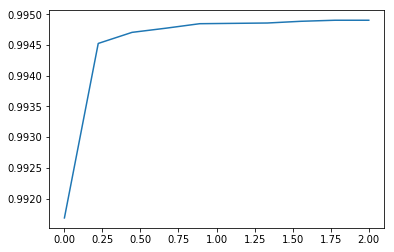

In [75]:
plt.plot(Cs, log_c_scores)

In [53]:
print(np.max(log_c_scores))
print(Cs[np.argmax(log_c_scores)])

0.9949011791181643
2.0


In [64]:
%%time
logCV = LogisticRegression(n_jobs = -1, C=Cs[np.argmax(log_c_scores)])
                           
try_out(logCV)

Оценка на кросc валидации: 0.9904376117507218
Оценка на отложенной выборке: 0.9904394993763576
Wall time: 8min 25s


Как видим результат практически не изменился

Теперь построим кривую обучения

In [76]:
def plot_learning_curve(estimator, X, y, cv=None):
    parts = np.linspace(.1, 1.0, 10)
    plt.figure()
    plt.title('LogisticRegression')
    plt.xlabel("Training examples")
    plt.ylabel('roc_auc score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=parts, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend()
    return plt

Wall time: 10min 23s


<module 'matplotlib.pyplot' from 'D:\\Programs_2\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

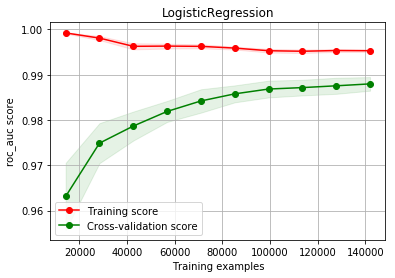

In [77]:
%%time
plot_learning_curve(LogCV, X_train, y_train, cv=skf)

Теперь сделаем решение и запишем его в файл

In [85]:
logCV.fit(train_sparse, y)
solution = logCV.predict_proba(test_sparse)
to_submission(solution, 'solution.csv')

## Оценка модели и выводы

Задача по идентификации отдельного пользователя, основываясь на его информационном следе в интернете, решается моделью довольно неплохо. Применятся она может, например:
* Кластеризируем большую группы пользователей, в подгруппы, основываясь на полученных фичах. После этого можно будет узнать с пользователями из каких групп Элис имеет большое сходство. И если бы мы знали Элис или её интересы в реальной жизни, например она художник, и мы знаем что она использует для своей работы. Из этого мы сможем предположить, что группа к которой её отнесли будет нуждатся в тех же вещах что и она, и сможем так таргетировать для них некоторые товары, на часто посещаемые ими сайты. Также мы сразу же сможем увидеть какие сайты популярны в ее группе, и если Элис ими еще не пользуется порекомендовать их ей, возможно они будут ей поезны
* Также если все пользователи были-бы размечены (известны их имена и например страницы в соцсетях) можно было-бы как-то знакомить похожих друг на друга пользователей.  
* Можно использовать модель для слежки за пользователем, если-бы Элис зашла с другого устройства можно будет определить её по её поведению в сети.
* Также например если Элис врач, и у нас будет еще несколько таких пользователей-врачей с подробной историей посещения сайтов, можно будет таргетировать например обьявления пойска врачей на часто посещаемые ими в отличие от остальных сатйты. Это предложение наверно похоже на первое.
***
В дальнейшем для улучшения модели можно попробовать использовать Tfidf, а также отфильтровать некоторые созданые признаки 